In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
#path = "/Users/argelia/Documents/Trabajo/TrabajoNestor/Data/Blok_McGaugh_Rubin_2001/"
#data = np.loadtxt(path+"ESO3020120.dat")
path="/Users/namh2/Downloads/anterior/ajusteTOV/"
data=np.loadtxt(path+"datos.txt")

In [3]:
RCr_data = np.array([row[1] for row in data])# galactocentric distance [kpc]
RCv_data = np.array([row[5] for row in data])# rotation velocity [km/s]
RCev_data = np.array([row[6] for row in data])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

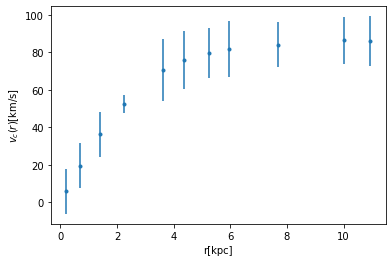

In [4]:
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [5]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    #while x0 < x:
    #while y0[1] > 0.0001*x:
    while y0[1] > 1.e-13:
         # Count number of iterations using step size or
        #h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [6]:
def rhs(x,y):
    dy=np.zeros(2)
    dy[0]=3.*x**2*(y[1]/K)**(1./g)
    dy[1]=-Gs*y[0]/x**2*(y[1]/K)**(1./g)
    return dy

In [7]:
def model(data,X,Y):
    V = []
    RC=np.sqrt(G*Y[:,0]/X)
    Int_l = interpolate.interp1d(X,RC)#,fill_value='extrapolate')
    for i in range(len(data)):
        if data[i] < X[-1]:
            v=Int_l(data[i])
            V.append(v)
        else:
            v=np.sqrt(G*Y[:,0][-1]/(data[i]))
            V.append(v)
    return V,RC 

In [8]:
def Xi2(RCv_data,RCv_teo,RCev_data):
    xi=np.sum((RCv_data-RCv_teo)**2./(RCev_data)**2.)
    return xi

In [9]:
Gs=4.785*10**(-7)
G=4.258*10**(4)
y0=np.zeros(2)
h=0.01

In [26]:
#K=1.*10**(-6)
#g=1.7
K_min=7*10**(-7)
K_max=1.1*10**(-6)
K_min=3*10**(-7)
K_max=1.5*10**(-6)
K_min=1*10**(-7)
K_max=0.5*10**(-6)
Kvec=np.linspace(K_min,K_max,15)
p_0min=5.56*10**(-10)
p_0max=5.98*10**(-10)
p_0=np.linspace(p_0min,p_0max,15)
g_min=1.03
g_max=1.7
gvec=np.linspace(g_min,g_max,15)

In [27]:
%%time
xi_minimo=1000
xi = np.zeros((len(p_0),len(gvec),len(Kvec)))
for l in range(0,len(Kvec)):
    K=Kvec[l]
    for j in range(0,len(gvec)):
        g=gvec[j]
        for i in range(0,len(p_0)):
            x0=0.0001
            y0[0]=0
            y0[1]=p_0[i]
            X,Y=Integrate(rhs,x0,y0,p_0[i],h)
            V,RC=model(RCr_data,X,Y)
            xi[i,j,l]=Xi2(RCv_data,V,RCev_data)
            if (xi[i,j,l] < xi_minimo):
                xi_minimo=xi[i,j,l]
                p0_minimo=p_0[i]
                g_minimo=gvec[j]
                K_minimo=Kvec[l]

Wall time: 37min 48s


In [28]:
print(xi_minimo)
print(K_minimo)
print(p0_minimo)
print(g_minimo)

0.723883159532784
1e-07
5.980000000000001e-10
1.2214285714285715


In [29]:
print(xi_minimo)
print(K_minimo)
print(p0_minimo)
print(g_minimo)

0.723883159532784
1e-07
5.980000000000001e-10
1.2214285714285715


In [30]:
xi_p0 = np.zeros((len(gvec),len(Kvec)))
for j in range(0,len(gvec)):
    for l in range(0,len(Kvec)):
        xi_p0minimo=10000
        for i in range(0,len(p_0)):  
            if (xi[i,j,l] < xi_p0minimo):
                xi_p0minimo=xi[i,j,l]
                xi_p0[j,l]=xi_p0minimo
min_p0=100000
for j in range(0,len(gvec)):
    for l in range(0,len(Kvec)):
        if (xi_p0[j,l] < min_p0):
            min_p0=xi_p0[j,l]
            min_gp0=gvec[j]
            min_Kp0=Kvec[l]
print(min_p0)
print(min_Kp0)
print(min_gp0)

0.723883159532784
1e-07
1.2214285714285715


In [31]:
xi_K = np.zeros((len(gvec),len(p_0)))
for j in range(0,len(gvec)):
    for l in range(0,len(p_0)):
        xi_Kminimo=10000
        for i in range(0,len(Kvec)):  
            if (xi[l,j,i] < xi_Kminimo):
                xi_Kminimo=xi[l,j,i]
                xi_K[l,j]=xi_Kminimo
min_K=100000
for j in range(0,len(gvec)):
    for l in range(0,len(p_0)):
        if (xi_K[l,j] < min_K):
            min_K=xi_K[l,j]
            min_gK=gvec[j]
            min_p0K=p_0[l]
print(min_K)
print(min_p0K)
print(min_gK)

0.723883159532784
5.980000000000001e-10
1.2214285714285715


In [32]:
xi_g = np.zeros((len(Kvec),len(p_0)))
for j in range(0,len(Kvec)):
    for l in range(0,len(p_0)):
        xi_gminimo=10000
        for i in range(0,len(gvec)):  
            if (xi[l,i,j] < xi_gminimo):
                xi_gminimo=xi[l,i,j]
                xi_g[l,j]=xi_gminimo
min_g=10000
for j in range(0,len(Kvec)):
    for l in range(0,len(p_0)):
        if (xi_g[l,j] < min_g):
            min_g=xi_g[l,j]
            min_Kg=Kvec[j]
            min_p0g=p_0[l]
print(min_g)
print(min_Kg)
print(min_p0g)

0.723883159532784
1e-07
5.980000000000001e-10


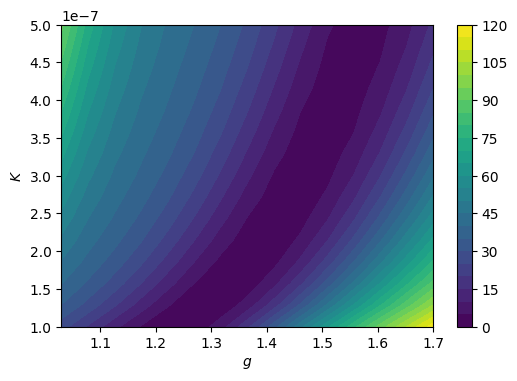

In [33]:
x,y = np.meshgrid(Kvec,gvec)
fig = plt.figure(dpi=100)
plt.contourf(y,x,xi_p0,25,cmap='viridis')
plt.xlabel(r'$g$')
plt.ylabel(r'$K$')
plt.colorbar();

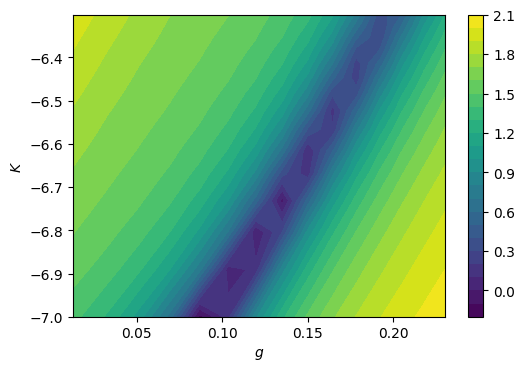

In [34]:
x,y = np.meshgrid(np.log10(Kvec),np.log10(gvec))
fig = plt.figure(dpi=100)
plt.contourf(y,x,np.log10(xi_p0),25,cmap='viridis')
plt.xlabel(r'$g$')
plt.ylabel(r'$K$')
plt.colorbar();

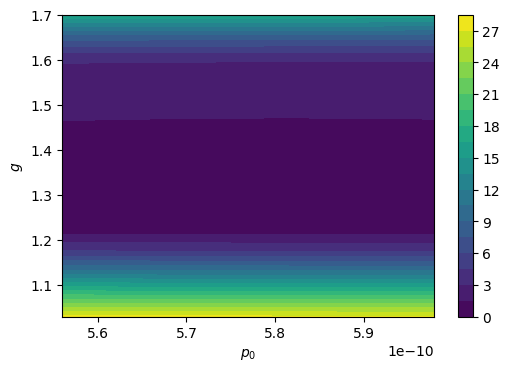

In [35]:
x,y = np.meshgrid(gvec,p_0)
fig = plt.figure(dpi=100)
plt.contourf(y,x,xi_K,25,cmap='viridis')
plt.xlabel(r'$p_0$')
plt.ylabel(r'$g$')
plt.colorbar();

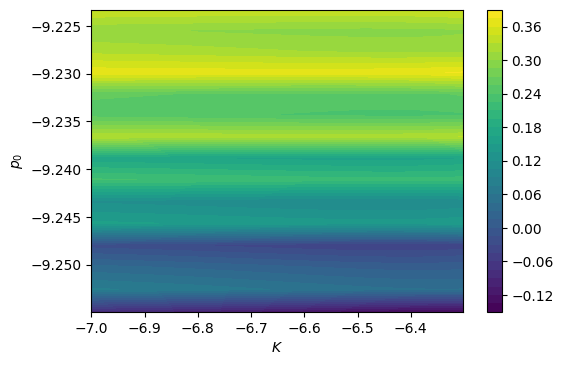

In [36]:
x,y = np.meshgrid(np.log10(p_0),np.log10(Kvec))
fig = plt.figure(dpi=100)
plt.contourf(y,x,np.log10(xi_g),45,cmap='viridis')
plt.xlabel(r'$K$')
plt.ylabel(r'$p_0$')
plt.colorbar();

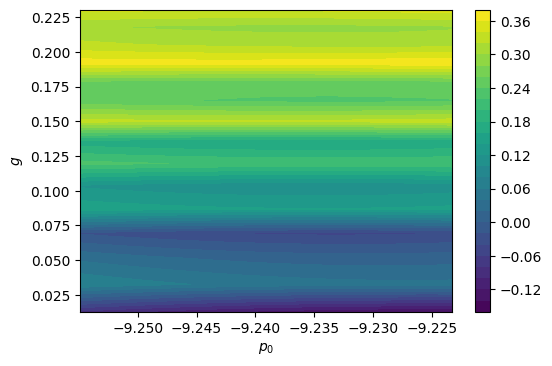

In [37]:
x,y = np.meshgrid(np.log10(gvec),np.log10(p_0))
fig = plt.figure(dpi=100)
plt.contourf(y,x,np.log10(xi_g),25,cmap='viridis')
plt.xlabel(r'$p_0$')
plt.ylabel(r'$g$')
plt.colorbar();

Text(0.5, 0, '$\\chi^2$')

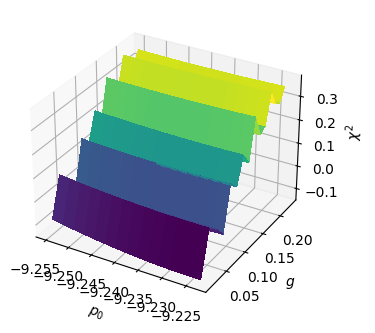

In [38]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=100)
surf = ax.plot_surface(y,x,np.log10(xi_g),cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$p_0$')
ax.set_ylabel(r'$g$')
ax.set_zlabel(r'$\chi^2$')

In [ ]:
plt.plot(p_0,xi)

In [ ]:
xi_minimo

In [ ]:
p0_minimo

In [ ]:
g_minimo

In [ ]:
xi_minimo

In [ ]:
K_minimo

In [39]:
x0=0.0001
K=K_minimo
g=g_minimo
y0[1]=p0_minimo
X,Y=Integrate(rhs,x0,y0,p0_minimo,h)
V,RC=model(RCr_data,X,Y)

<ErrorbarContainer object of 3 artists>

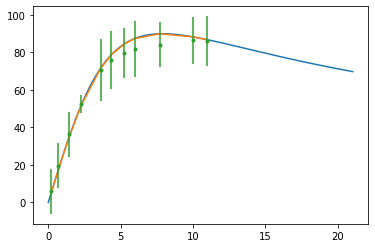

In [40]:
plt.plot(X,RC)
plt.plot(RCr_data,V)
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')

In [ ]:
2.417196664395324
7e-07
5.86e-10
1.6428571428571428
2.5582023553186675
8e-07
5.89e-10
1.6714285714285713
x0=0.0001
K=8*10**(-7)
p_0=5.89e-10
g=1.6714285714285713
y0[0]=0
y0[1]=p_0
X,Y=Integrate(rhs,x0,y0,p0_minimo,h)
V,RC=model(RCr_data,X,Y)
Xi2(RCv_data,V,RCev_data)

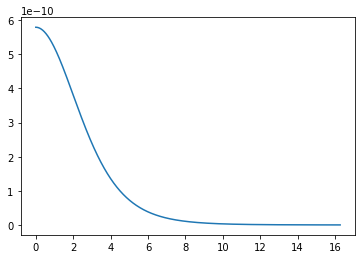

In [25]:
plt.plot(X,Y[:,1])

In [ ]:
plt.plot(X,RC)
plt.plot(RCr_data,V)
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')